### Using this git as reference for CNN edge detection

https://tonio73.github.io/data-science/cnn/CnnEdgeDetection-Keras-Part1.html

In [99]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorview as tv

from tensorflow.keras import models, layers, losses, activations, regularizers, metrics
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [3]:
image = Image.open(f'coaerogel.tif')

In [5]:
patch_size = (50,50)
output_dir = 'patches'
os.makedirs(output_dir, exist_ok=True)

image_width, image_height = image.size

for i in range(0, image_width, patch_size[0]):
    for j in range(0, image_height, patch_size[1]):
        box = (i, j, i + patch_size[0], j + patch_size[1])

        patch = image.crop(box)

        if patch.size == patch_size:
            patch_filename = os.path.join(output_dir, f'patch_{i}_{j}.tif')
            patch.save(patch_filename)

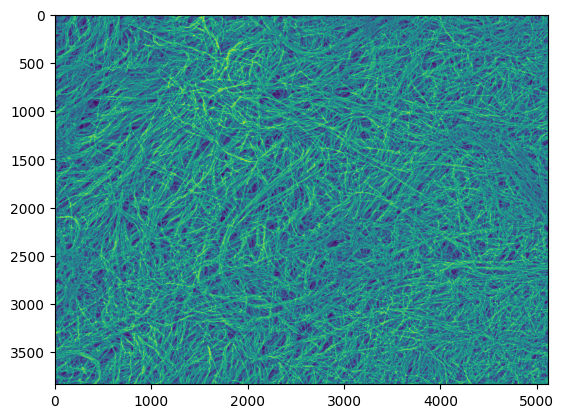

In [33]:
image = image.convert("L") # Convert to grayscale
image_array = np.array(image)
plt.imshow(np.array(image_array))
img_height, img_width = image_array.shape

In [36]:
image_array[5,10]

74

In [28]:
Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) # Sobel operator horiz. edge detect.
Ky = Kx.T # Sobel operator for vert edge detect.

In [37]:
convolvedShape = (img_height - 2, img_width - 2)
imgEdges1x = np.zeros(convolvedShape) # Horiz
imgEdges1y = np.zeros(convolvedShape) # Vert
imgEdges1 = np.zeros(convolvedShape) # Combined

for i in range(1, img_height - 1):
    for j in range(1, img_width - 1):
        window = image_array[i-1:i+2, j-1:j+2]
        a = imgEdges1x[i-1, j-1] = np.maximum(np.sum(np.multiply(window, Kx)), 0)
        b = imgEdges1y[i-1, j-1] = np.maximum(np.sum(np.multiply(window, Ky)), 0)
        imgEdges1[i-1, j-1]      = np.sqrt(a**2 + b**2)

Text(0.5, 1.0, 'Combined')

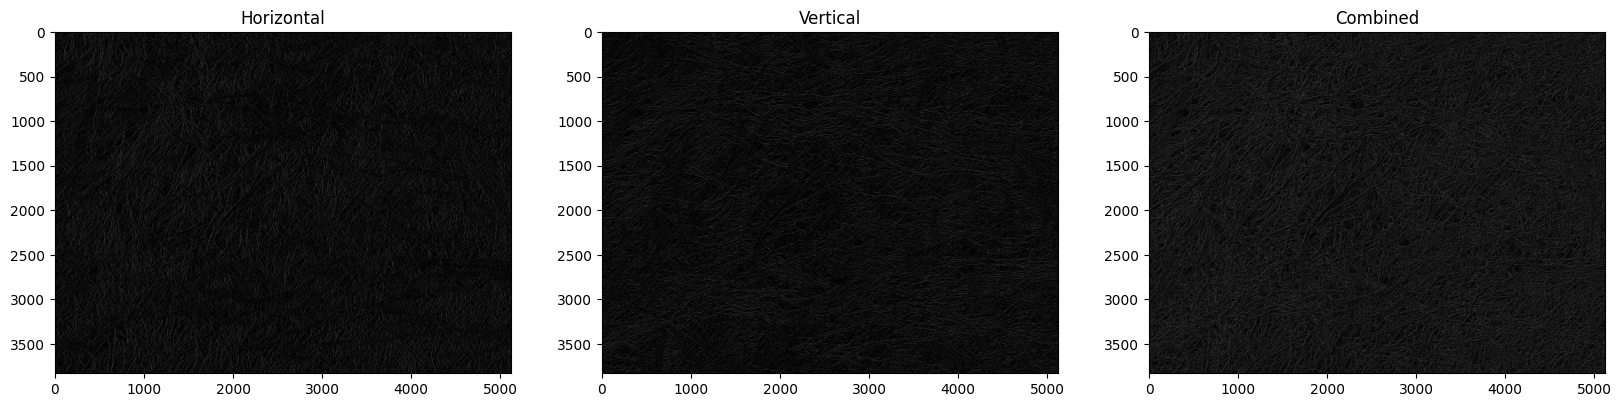

In [38]:
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.imshow(imgEdges1x, cmap='gray');
plt.title('Horizontal')
plt.subplot(1,3,2)
plt.imshow(imgEdges1y, cmap='gray');
plt.title('Vertical')
plt.subplot(1,3,3)
plt.imshow(imgEdges1, cmap='gray');
plt.title('Combined')

### CNN

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Text(0.5, 1.0, 'Test estimate')

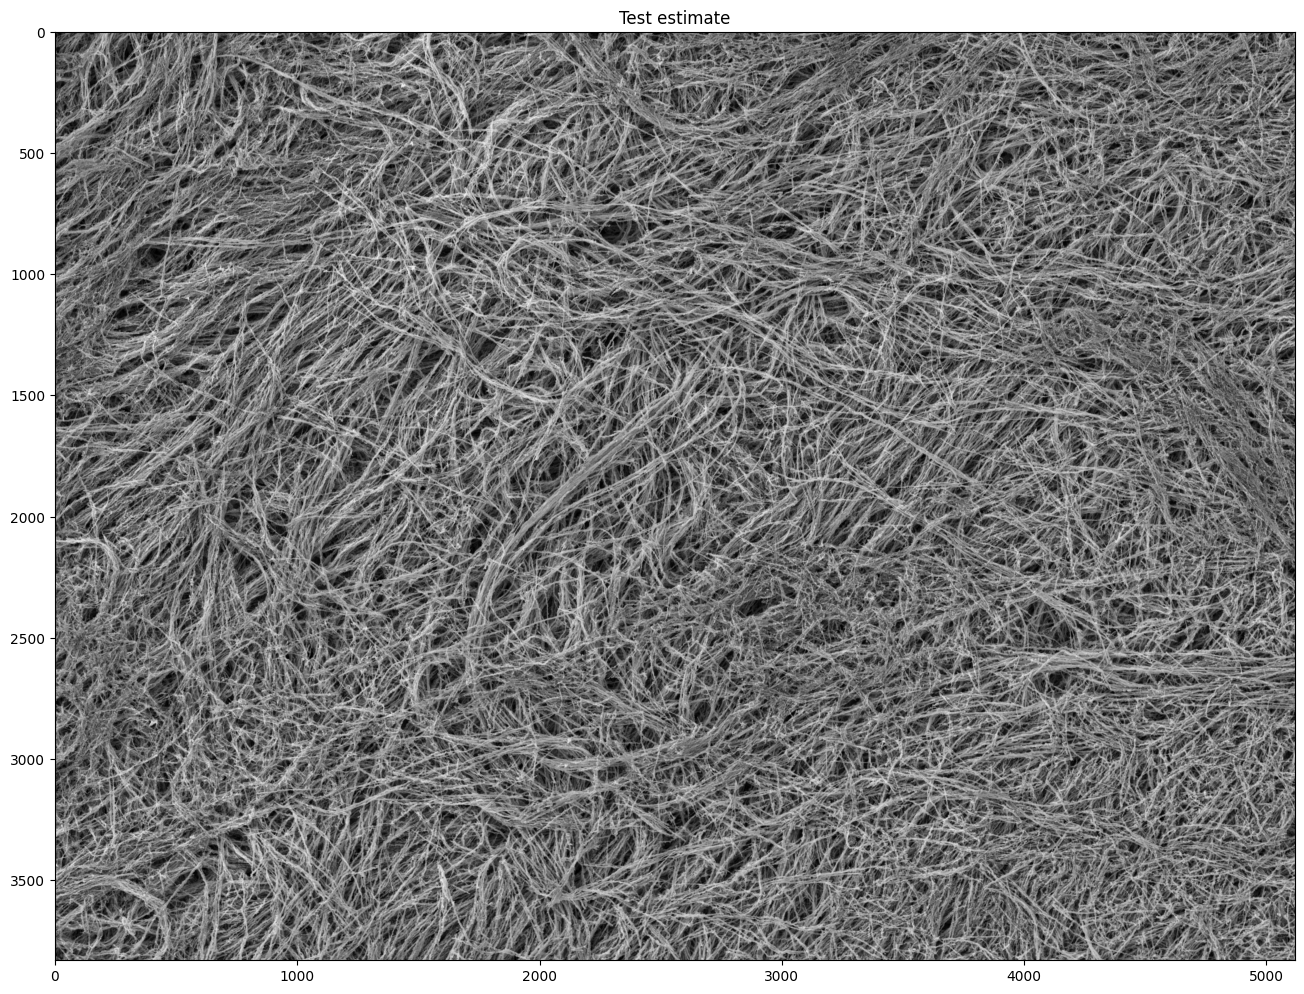

In [97]:
imageNChannels = 1
nEpochs = 4000
batchSize = 128
nConv = 2

# Define the model
model0 = models.Sequential([
    layers.Conv2D(nConv, (3, 3), activation=activations.linear,  # 2D convolution
                input_shape=(None, None, imageNChannels), use_bias=True,
                kernel_regularizer=regularizers.l1(0.0001),
                bias_regularizer=regularizers.l1(0.01)
            ),
    layers.LeakyReLU(),
    layers.Dense(1, kernel_regularizer=regularizers.l1(0.0001)), # Dense layer to combine convolutions
    layers.LeakyReLU(),
    layers.Dense(1, kernel_regularizer=regularizers.l1(0.0001)), # Dense layer to combine convolutions
    layers.LeakyReLU(),
    layers.Dense(1, kernel_regularizer=regularizers.l1(0.0001)), # Dense layer to combine convolutions
    layers.LeakyReLU(),
    layers.Dense(1, kernel_regularizer=regularizers.l1(0.0001)), # Dense layer to combine convolutions
    layers.Flatten()  
], name='model0')

testImage = image_array.reshape(1, img_height, img_width, 1) / 255
testEst0 = model0.predict(testImage)
testEstEdges0 = (testEst0.reshape(img_height-2, img_width-2)) * 255

plt.figure(figsize=(16, 16))
plt.imshow(testEstEdges0, cmap='gray');
plt.title('Test estimate')

In [59]:

trainHeight, trainWidth = 64, 64
inputBatchShape = (-1, trainHeight, trainWidth, imageNChannels)
trainImage  = image_array.reshape(inputBatchShape) / 255.

# Get the output of the fitler using model0 (filter with predefined weights)
trainImageHeight, trainImageWidth = image_array.shape[0], image_array.shape[1]
trainEst0 = model0.predict(image_array.reshape(1, trainImageHeight, trainImageWidth, 1) / 255.)
trainEstEdges0 = np.pad((trainEst0.reshape(trainImageHeight-2, trainImageWidth-2)) * 255., (1,1), mode='constant')

# Reshape into sub-images as "Labels" for the trainer
outPutBatchShape = (-1, (trainHeight-2) * (trainWidth-2), imageNChannels)
trainLabels = trainEstEdges0.reshape(inputBatchShape)
trainLabels = trainLabels[:, 1:-1, 1:-1,:].reshape(outPutBatchShape) / 255.
trainImage.shape, trainLabels.shape

ValueError: cannot reshape array of size 19630080 into shape (64,64,1)

In [60]:
image_array[0]

array([147, 130, 115, ...,  33,  31,  41], dtype=uint8)

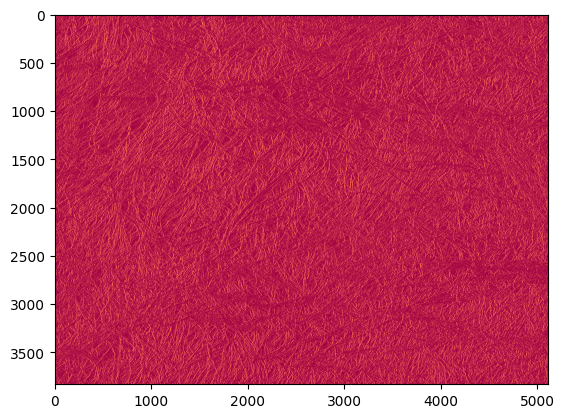

In [64]:
plt.imshow(testEstEdges0, cmap='Spectral')

Feature extraction using pre-trained VG116

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/ste

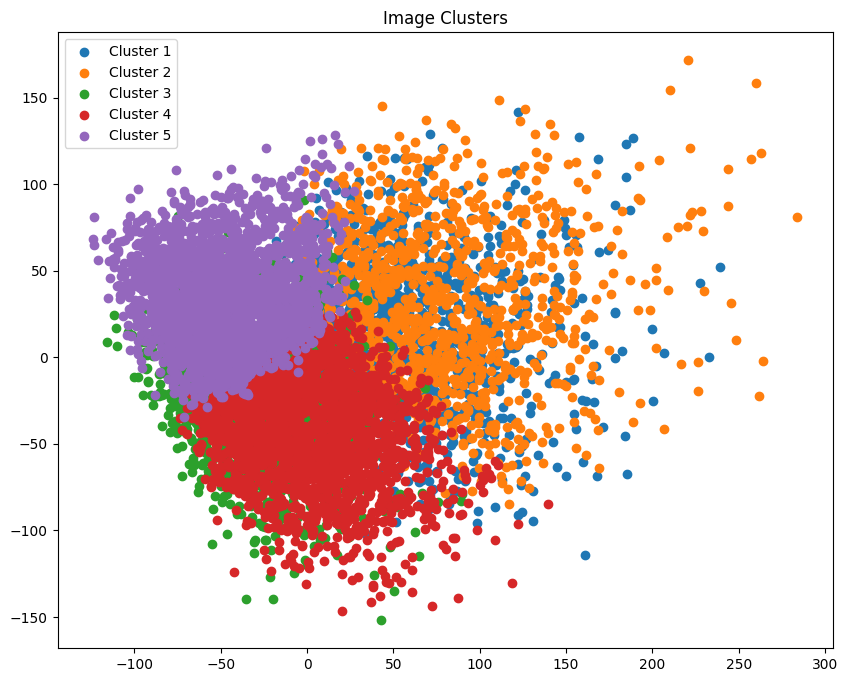

In [101]:
# Directory containing all images
image_dir = 'patches'

# Load the pre-trained VGG16 model + higher level layers
model = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Initialize list to hold image features
features_list = []

# Load and process each image
for image_file in os.listdir(image_dir):
    img_path = os.path.join(image_dir, image_file)
    img = load_img(img_path, target_size=(50, 50))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Extract features
    features = model.predict(img_array)
    features = features.flatten()
    features_list.append(features)

# Convert to numpy array
features_array = np.array(features_list)

# Optionally reduce dimensionality with PCA
pca = PCA(n_components=50)  # Reduce to 50 dimensions
reduced_features = pca.fit_transform(features_array)

# Perform KMeans Clustering
num_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(reduced_features)

# Get cluster assignments
labels = kmeans.labels_

# Optional: Visualize the clusters
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    cluster = reduced_features[labels == i]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i+1}')
plt.legend()
plt.title('Image Clusters')
plt.show()

In [110]:
sum(i != 0 for i in features_list)

array([ 795,   53, 4802,  662, 1491,   84,  277, 4401,  286,   17,   59,
          1,  979,  208,   46,    3,  142,  222,    1,   21, 7229, 1379,
         61,  384,    0,    4,   24,  493, 1525,  143,  217,  104, 2746,
          4,  780,    4,   88,  478, 5629, 2139,  684,   27,  264,   13,
        665,  236,  995,  156,   13, 5042,   21, 1148,  151,    0, 1187,
       5483, 3375, 1432,  843,    2,  519,  347,  374,   90,  180,  208,
        131,  257,  137,  201,  201,  155, 5013,   37,  778,   73, 3276,
         20,   23,   10, 3057,  178,   10,   69, 1632,   65,    1,    1,
       4312,    3,   12,  481,   47,   11,  253,   19, 2167,  311,   10,
        193,  664,  335,  132, 4347, 3043, 4803, 7421,    0,   30,  359,
       3575,    4, 1168, 1550,   23,  389, 5219, 5184, 2406,   60,   47,
       1146,    4,  193,  391, 1615,   67, 6283, 1234,  176,   71, 1755,
       2435,    1,    0,  273,  889,  150,  779,  604,    3,  444,   74,
       1998,   16,   43,  778,   18,   12, 5675, 10

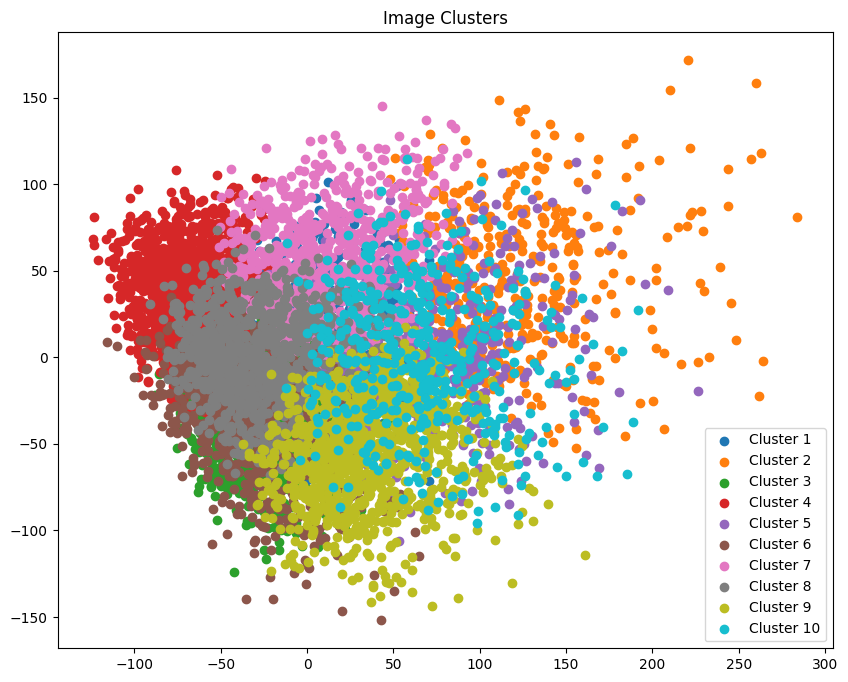

In [116]:
# Perform KMeans Clustering
num_clusters = 10  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(reduced_features)

# Get cluster assignments
labels = kmeans.labels_

# Optional: Visualize the clusters
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    cluster = reduced_features[labels == i]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i+1}')
plt.legend()
plt.title('Image Clusters')
plt.show()

In [112]:
len(features_array)

7931

In [114]:
len(labels)

7931

In [115]:
labels[0:10]

array([21, 28, 28,  9, 13, 27, 22, 28, 28, 28])

In [124]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters
import random
import tensorflow as tf

- Below script will do the following for each of the patches:
    - load the 50 x 50 patch
    - convert to grayscale/remove transparency later in tif...
    - conduct prewitt edge detection
    - hough transform to find lines
    - extract angles between all hough lines
    - look at the binned density of all angles
    - take the two primary angles to see how the fibers are generally arrayed in the patch

In [138]:
# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Load the image
image = np.array(Image.open(f'patches/patch_0_350.tif').convert('RGB'))

In [139]:
# Convert the image to grayscale (if not already)
if len(image.shape) == 3:
    gray_image = color.rgb2gray(image)
else:
    gray_image = image

- https://en.wikipedia.org/wiki/Sobel_operator
- https://en.wikipedia.org/wiki/Prewitt_operator
- https://en.wikipedia.org/wiki/Hough_transform

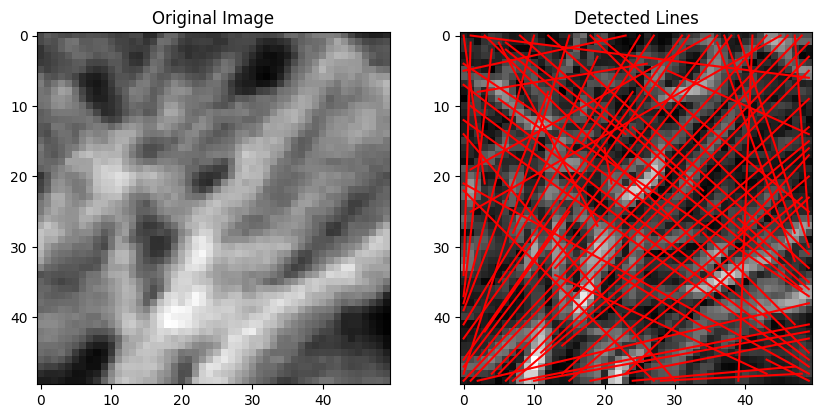

In [145]:
# Apply Sobel edge detection
edges = filters.prewitt(gray_image)

# Use the Hough Transform to detect lines
hough_lines = cv2.HoughLinesP((edges * 255).astype(np.uint8), 1, np.pi / 180, threshold=10, minLineLength=5, maxLineGap=3)

# Plot the original image and detected lines
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(edges, cmap='gray')
if hough_lines is not None:
    for line in hough_lines:
        x1, y1, x2, y2 = line[0]
        plt.plot([x1, x2], [y1, y2], color='red')
plt.title('Detected Lines')

plt.show()


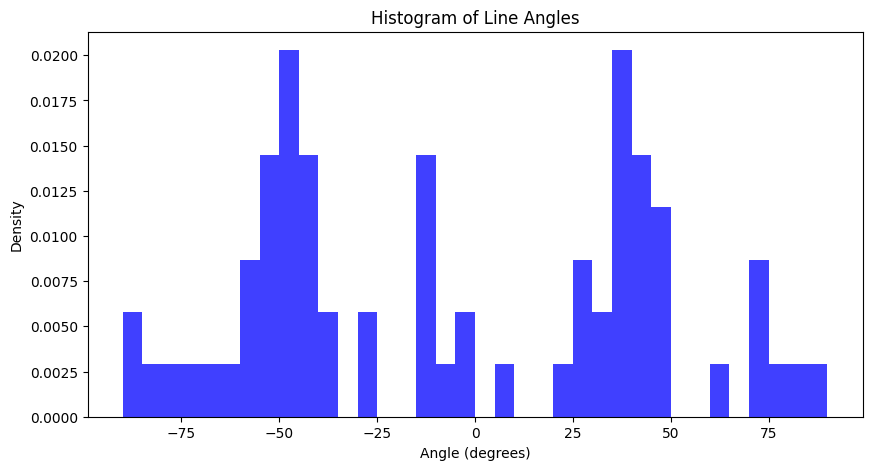

The two primary directions are approximately 35.00° and -50.00°.


In [146]:
# Apply Prewitt edge detection
edges = filters.prewitt(gray_image)

# Use the Hough Transform to detect lines
hough_lines = cv2.HoughLinesP((edges * 255).astype(np.uint8), 1, np.pi / 180, threshold=10, minLineLength=5, maxLineGap=3)

# Extract angles of the detected lines
angles = []
if hough_lines is not None:
    for line in hough_lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2 - y1, x2 - x1) * (180.0 / np.pi)  # Convert to degrees
        angles.append(angle)

# Convert angles to numpy array for analysis
angles = np.array(angles)

# Plot histogram of angles
plt.figure(figsize=(10, 5))
plt.hist(angles, bins=36, range=(-90, 90), density=True, alpha=0.75, color='blue')
plt.title('Histogram of Line Angles')
plt.xlabel('Angle (degrees)')
plt.ylabel('Density')

# Identify the two primary directions (peaks in the histogram)
counts, bin_edges = np.histogram(angles, bins=36, range=(-90, 90))
primary_directions = bin_edges[np.argsort(counts)[-2:]]  # Get the bins with the two highest counts

plt.show()

print(f"The two primary directions are approximately {primary_directions[0]:.2f}° and {primary_directions[1]:.2f}°.")

- So this is for one patch, could iterate through this and then grid overlay a heat map of the angle differences?

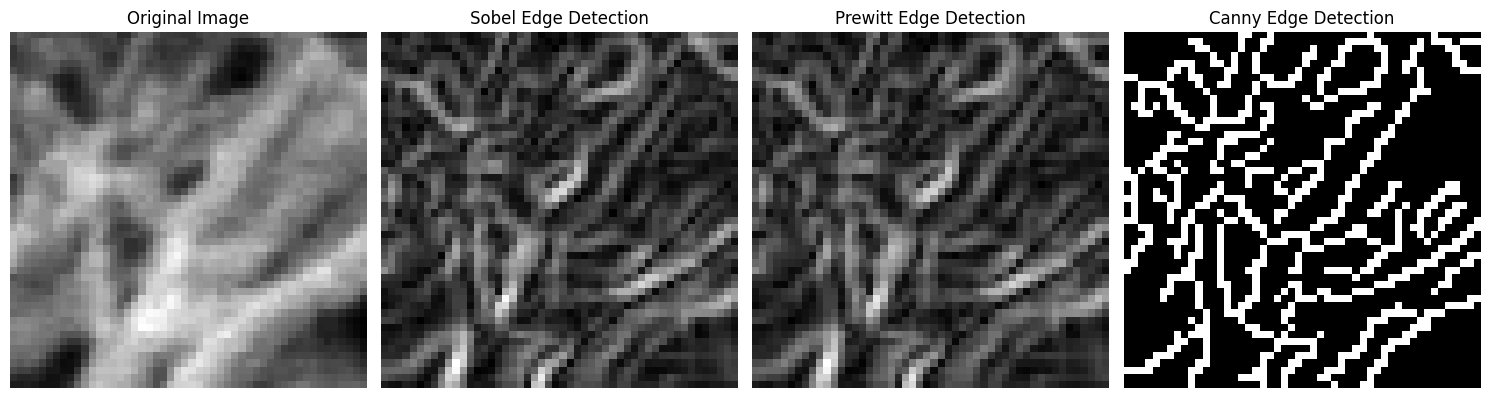

In [141]:
# Apply Sobel edge detection
edges_sobel = filters.sobel(gray_image)

# Apply Prewitt edge detection
edges_prewitt = filters.prewitt(gray_image)

# Apply Canny edge detection
# Canny needs the image to be in 8-bit format, so scale it
gray_image_8bit = (gray_image * 255).astype(np.uint8)
edges_canny = cv2.Canny(gray_image_8bit, 100, 200)

# Plotting the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(edges_sobel, cmap='gray')
plt.title('Sobel Edge Detection')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(edges_prewitt, cmap='gray')
plt.title('Prewitt Edge Detection')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(edges_canny, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')

plt.tight_layout()
plt.show()